In [1]:
from uniprobe_data import *
from sqlalchemy import func
from sqlalchemy import distinct

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggstyle')

In [3]:
import networkx as nx
import numpy as np

## Create networks for each Gene, identified by gene_id

In [4]:
def id2kmer(kmer_id, kmer_length=8):
    assert(kmer_id < 4 ** kmer_length - 1)

    alphabet = 'ACGT'
    
    kmer = ''
    while kmer_id > 0:
        nt_id = kmer_id % 4
        nt = alphabet[nt_id]

        kmer = nt + kmer
        kmer_id = (kmer_id - nt_id) / 4

    # To correct for cases in which A's are at the front of the string 
    # (which equal 0, so are left out by loop)
    while len(kmer) < kmer_length:
        kmer = 'A' + kmer
    
    return kmer

def kmer2id(kmer):
    
    inv_alphabet = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    kmer_id = 0
    for nt in kmer:
        kmer_id = 4 * kmer_id + inv_alphabet[nt]

    return kmer_id

In [174]:
def snps(seed, alphabet='ACGT'):

    seqs = set()
    for i,s in enumerate(seed):
        seqs |= {l.join([seed[:i], seed[i + 1:]]) for l in alphabet if l != s}

    return seqs

Create pickled graphs in the graphs folder

In [ ]:
cutoff = 0.35
q = session.query(Gene).order_by(Gene.gene_id)

for gene in q:
    g = nx.empty_graph()

    for contig in gene.contigs:
        if contig.enrichment_score >= cutoff:
            seq = id2kmer(contig.kmer)

            g.add_node(seq, enrichment_score=contig.enrichment_score)
            for mutant in snps(seq):
                if mutant in g:
                    g.add_edge(seq, mutant)

    nx.write_gpickle(g, 'graphs/' + str(gene.gene_id) + '.escore' + str(cutoff) + '.pickle.bz2')

### Graph comparison - GeneData.uniprot-wise

In [4]:
import numpy as np

def similarity(g, h):
    """
    Returns three similarity measures (the Jaccard index [1], the cosine similarity [2] 
    and the min similarity [3]) for two sets g and h.
    
    [1] P. Jaccard, Bulletin de la Société Vaudoise des Sciences Naturelles 37, 547 (1901).
    [2] Salton, Automatic Text Processing: The Transformation, Analysis, and Retrieval of 
        Information by Computer (Addison-Wesley, Reading, MA, 1989).
    [3] E. Ravasz, A. L. Somera, D. A. Mongru, Z. N. Oltvai, and 
        A.-L. Barabási, Science 297, 1553 (2002).
        
    The Jaccard similarity measure is redefined such that when the two sets are empty
    the similiraty is zero (not one).
    """

    n = 1.0 * len(g & h)
    u = 1.0 * len(g | h)
    lg, lh = len(g), len(h)
    return (0.0 if (lg == 0 and lh == 0) else (n / u if u != 0.0 else np.nan),
            n / np.sqrt(lg * lh) if (lg != 0 and lh != 0) else np.nan,
            n / np.min([lg, lh]) if np.min([lg, lh]) != 0 else np.nan)

In [5]:
import networkx as nx

def net_similarity(g, h):
    """
    """
    return similarity(set(g.nodes()), set(h.nodes()))

In [6]:
bind_net = dict()
for gene_data in session.query(GeneData):
#     bind_net[gene_data.uniprot] =\
#         nx.read_gpickle('graphs/' + str(gene_data.gene_info.genes[0].gene_id) + '.escore0.35.pickle.bz2')
    bind_net[gene_data.uniprot] =\
        set(nx.read_gpickle('graphs/' + str(gene_data.gene_info.genes[0].gene_id) + '.escore0.35.pickle.bz2').nodes())

/usr/local/lib/python2.7/dist-packages/sqlalchemy/orm/strategies.py:608: SAWarning: Multiple rows returned with uselist=False for lazily-loaded attribute 'GeneData.gene_info' 
  % self.parent_property)


In [7]:
with open('graphs.escore0.35.vs', 'w') as graph_vs:

    for gd1 in session.query(GeneData):
        for gd2 in session.query(GeneData):

#             x = net_similarity(bind_net[gd1.uniprot], bind_net[gd2.uniprot])
            x = similarity(bind_net[gd1.uniprot], bind_net[gd2.uniprot])
            graph_vs.write('%s\t%s\t%g\t%g\t%g\n' % (gd1.uniprot, gd2.uniprot, x[0], x[1], x[2]))

In [8]:
!head graphs.escore0.35.vs

Q8IKH2	Q8IKH2	1	1	1
Q8IKH2	Q5CTD3	0.566667	0.72631	0.794393
Q8IKH2	P41936	0	0	0
Q8IKH2	P14859	0.0110375	0.0339886	0.0934579
Q8IKH2	O70137	0	0	0
Q8IKH2	O35137	0	0	0
Q8IKH2	O35085	0	0	0
Q8IKH2	P97503	0.00105042	0.00332371	0.00934579
Q8IKH2	P63157	0	0	0
Q8IKH2	Q8VIB5	0	0	0


In [ ]:
del bind_net

##TF comparison

In [14]:
!grep P63013 graphs.escore0.35.vs | grep P70390 -

P63013	P70390	0.776889	0.874587	0.890928
P70390	P63013	0.776889	0.874587	0.890928


In [16]:
len(bind_net['P63013']), len(bind_net['P70390'])

(981, 1018)

In [15]:
similarity(bind_net['P63013'], bind_net['P70390'])

(0.7768888888888889, 0.87458704492684125, 0.890927624872579)

In [29]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'P63013')[0]
gd.gene_info.genes[0].gene_id

266

In [30]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'P70390')[0]
gd.gene_info.genes[0].gene_id

257

####high  escore, low dist

<matplotlib_venn._common.VennDiagram instance at 0x7ff4f84e8c20>

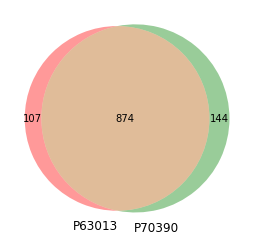

In [34]:
from matplotlib_venn import venn2
venn2([bind_net['P63013'], bind_net['P70390']], set_labels = ('P63013', 'P70390'))

In [39]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'P63013')[0]
gd.fasta

u'>sp|P63013|PRRX1_MOUSE Paired mesoderm homeobox protein 1 OS=Mus musculus GN=Prrx1 PE=1 SV=1\nMTSSYGHVLERQPALGGRLDSPGNLDTLQAKKNFSVSHLLDLEEAGDMVAAQADESVGEAGRSLLESPGLTSGSDTPQQDNDQLNSEEKKKRKQRRNRTTFNSSQLQALERVFERTHYPDAFVREDLARRVNLTEARVQVWFQNRRAKFRRNERAMLANKNASLLKSYSGDVTAVEQPIVPRPAPRPTDYLSWGTASPYSAMATYSATCANNSPAQGINMANSIANLRLKAKEYSLQRNQVPTVN'

In [40]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'P70390')[0]
gd.fasta

u'>sp|P70390|SHOX2_MOUSE Short stature homeobox protein 2 OS=Mus musculus GN=Shox2 PE=2 SV=1\nMEELTAFVSKSFDQKVKEKKEAITYREVLESGPLRGAKEPGCVEPGRDDRSSPAVRAAGGGGGAGGGGGGGGGGGGGAGGGGAGGGAGGGRSPVRELDMGAAERSREPGSPRLTEVSPELKDRKDDAKGMEDEGQTKIKQRRSRTNFTLEQLNELERLFDETHYPDAFMREELSQRLGLSEARVQVWFQNRRAKCRKQENQLHKGVLIGAASQFEACRVAPYVNVGALRMPFQQDSHCNVTPLSFQVQAQLQLDSAVAHAHHHLHPHLAAHAPYMMFPAPPFGLPLATLAADSASAASVVAAAAAAKTTSKNSSIADLRLKAKKHAAALGL'

<matplotlib_venn._common.VennDiagram instance at 0x7ff4f20f57e8>

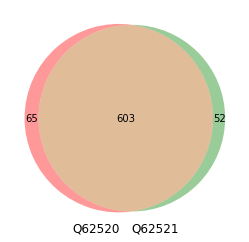

In [41]:
from matplotlib_venn import venn2
venn2([bind_net['Q62520'], bind_net['Q62521']], set_labels = ('Q62520', 'Q62521'))

In [42]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'Q62520')[0]
gd.fasta

u'>sp|Q62520|ZIC2_MOUSE Zinc finger protein ZIC 2 OS=Mus musculus GN=Zic2 PE=1 SV=2\nMLLDAGPQFPAIGVGSFARHHHHSAAAAAAAAAEMQDRELSLAAAQNGFVDSAAAHMGAFKLNPGAHELSPGQSSAFTSQGPGAYPGSAAAAAAAAALGPHAAHVGSYSGPPFNSTRDFLFRSRGFGDSAPGGGQHGLFGPGAGGLHHAHSDAQGHLLFPGLPPEQHGPHASQNVLNGQMRLGLPGEVFGRSEQYRQVASPRTDPYSAAQLHNQYGPMNMNMGMNMAAAAAHHHHHHHHPGAFFRYMRQQCIKQELICKWIDPEQLSNPKKSCNKTFSTMHELVTHVSVEHVGGPEQSNHVCFWEECPREGKPFKAKYKLVNHIRVHTGEKPFPCPFPGCGKVFARSENLKIHKRTHTGEKPFQCEFEGCDRRFANSSDRKKHMHVHTSDKPYLCKMCDKSYTHPSSLRKHMKVHESSPQGSESSPAASSGYESSTPPGLVSPSAEPQSSSNLSPAAAAAAAAAAAAAAAVSAVHRGAGSGSSGSGGGSAAGSGGGGGGAGGGGGGSSGGGSGTTGGHSGLSSNFNEWYV'

In [43]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'Q62521')[0]
gd.fasta

u'>sp|Q62521|ZIC3_MOUSE Zinc finger protein ZIC 3 OS=Mus musculus GN=Zic3 PE=1 SV=2\nMTMLLDGGPQFPGLGVGSFGAPRHHEMPNREPAGMGLNPFGDSTHAAAAAAAAAAFKLSPATAHDLSSGQSSAFTPQGSGYANALGHHHHHHHHHHASQVPTYGGAASAAFNSTRDFLFRQRGSGLSEAASGGGQHGLFAGSASSLHAPAGIPEPPSYLLFPGLHEQGAGHPSPTGHVDNNQVHLGLRGELFGRADPYRPVASPRTDPYAASAQFPNYSPMNMNMGVNVAAHHGPGAFFRYMRQPIKQELSCKWIEEAQLSRPKKSCDRTFSTMHELVTHVTMEHVGGPEQNNHVCYWEECPREGKSFKAKYKLVNHIRVHTGEKPFPCPFPGCGKIFARSENLKIHKRTHTGEKPFKCEFEGCDRRFANSSDRKKHMHVHTSDKPYICKVCDKSYTHPSSLRKHMKVHESQGSDSSPAASSGYESSTPPAIASANSKDTTKTPSAVQTSTSHNPGLPPNFNEWYV'

####low  escore, high dist

<matplotlib_venn._common.VennDiagram instance at 0x7ff4f2107170>

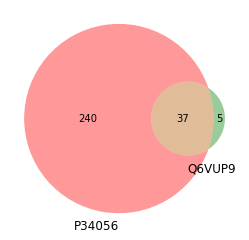

In [44]:
from matplotlib_venn import venn2
venn2([bind_net['P34056'], bind_net['Q6VUP9']], set_labels = ('P34056', 'Q6VUP9'))

In [45]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'P34056')[0]
gd.fasta

u'>sp|P34056|AP2A_MOUSE Transcription factor AP-2-alpha OS=Mus musculus GN=Tfap2a PE=1 SV=2\nMLWKLTDNIKYEDCEDRHDGTSNGTARLPQLGTVGQSPYTSAPPLSHTPNADFQPPYFPPPYQPIYPQSQDPYSHVNDPYSLNPLHAQPQPQHPGWPGQRQSQESGLLHTHRGLPHQLSGLDPRRDYRRHEDLLHGPHALGSGLGDLPIHSLPHAIEDVPHVEDPGINIPDQTVIKKGPVSLSKSNSNAVSAIPINKDNLFGGVVNPNEVFCSVPGRLSLLSSTSKYKVTVAEVQRRLSPPECLNASLLGGVLRRAKSKNGGRSLREKLDKIGLNLPAGRRKAANVTLLTSLVEGEAVHLARDFGYVCETEFPAKAVAEFLNRQHSDPNEQVARKNMLLATKQICKEFTDLLAQDRSPLGNSRPNPILEPGIQSCLTHFNLISHGFGSPAVCAAVTALQNYLTEALKAMDKMYLSNNPNSHTDNSAKSSDKEEKHRK'

In [46]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'Q6VUP9')[0]
gd.fasta

u'>sp|Q6VUP9|AP2E_MOUSE Transcription factor AP-2-epsilon OS=Mus musculus GN=Tfap2e PE=1 SV=2\nMLVHTYSAMERPDGLGAAAGGTRLSSLPQAAYGPAPPLCHTPAASATADYHPPYFPPPYPQAPLPYGQGPDATAAFPHLAADPYGGLAPLAQPQPPQAAWAAPRAAARAHDEPPGLLAPPARALGLDPRRDYAAAVPRLLHSLADGAHGLADAPLGLPGLAEPPGLEELQAIDDPGMSLLDQSVIKKVPIPSKAGSLSTLALSKDSLVGGISNPSEVFCSVPGRLSLLSSTSKYKVTVGEVQRRLSPPECLNASLLGGVLRRAKSKNGGRCLRERLEKIGLNLPAGRRKAANVTLLTSLVEGEAVHLARDFGYVCETEFPAKAAAEYLCRQHADPGELHSRKSMLLAAKQICKEFADLMAQDRSPLGNSRPALILEPGVQSCLTHFSLITHGFGGPAICAALTAFQNYLLESLKGLEKMFLSGAGGGHGESKASEKDTKHRK'

<matplotlib_venn._common.VennDiagram instance at 0x7ff4f20aad40>

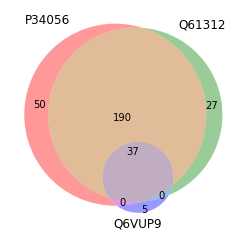

In [50]:
from matplotlib_venn import venn3
venn3([bind_net['P34056'], bind_net['Q61312'], bind_net['Q6VUP9']],
      set_labels = ('P34056', 'Q61312', 'Q6VUP9'))

In [48]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'P34056')[0]
gd.fasta

u'>sp|Q61312|AP2C_MOUSE Transcription factor AP-2 gamma OS=Mus musculus GN=Tfap2c PE=1 SV=2\nMLWKITDNVKYEEDCEDRHDSSSNGNPRIPHLSSPGQHLYSPAPPLSHTGVAEYQPPPYFPPPYQQLAYSQSADHYSHLGEAYAAAMNPLHQPAATGSQQQAWPGRQSQEGSSLASHHSRSASLIPHISGLEGGSVSARREVYRRSDLLLPHAHALEAGLAENLGLHEMAHPIEEVQNVDDAHLLLHDQTVIRKGPISMTKNPLGLPCQKDLVGVVMNPSEVFCSVPGRLSLLSSTSKYKVTVAEVQRRLSPPECLNASLLGGVLRRAKSKNGGRSLREKLDKIGLNLPAGRRKAAHVTLLTSLVEGEAVHLARDFAYVCEAEFPSKAVADYLTRPHLGGRNEMATRKSMLLAAQQVCKEFTDLLHQDRTPNGNNRPAQVLEPNIQNCLSHFSLITHGFGSQAICAAVSAVQNYIKEALIAIDKSYMNPGDQSPADSSKTMEKMEKHRK'

In [45]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'Q61312')[0]
gd.fasta

u'>sp|P34056|AP2A_MOUSE Transcription factor AP-2-alpha OS=Mus musculus GN=Tfap2a PE=1 SV=2\nMLWKLTDNIKYEDCEDRHDGTSNGTARLPQLGTVGQSPYTSAPPLSHTPNADFQPPYFPPPYQPIYPQSQDPYSHVNDPYSLNPLHAQPQPQHPGWPGQRQSQESGLLHTHRGLPHQLSGLDPRRDYRRHEDLLHGPHALGSGLGDLPIHSLPHAIEDVPHVEDPGINIPDQTVIKKGPVSLSKSNSNAVSAIPINKDNLFGGVVNPNEVFCSVPGRLSLLSSTSKYKVTVAEVQRRLSPPECLNASLLGGVLRRAKSKNGGRSLREKLDKIGLNLPAGRRKAANVTLLTSLVEGEAVHLARDFGYVCETEFPAKAVAEFLNRQHSDPNEQVARKNMLLATKQICKEFTDLLAQDRSPLGNSRPNPILEPGIQSCLTHFNLISHGFGSPAVCAAVTALQNYLTEALKAMDKMYLSNNPNSHTDNSAKSSDKEEKHRK'

In [51]:
gd = session.query(GeneData).filter(GeneData.uniprot == 'Q6VUP9')[0]
gd.fasta

u'>sp|Q6VUP9|AP2E_MOUSE Transcription factor AP-2-epsilon OS=Mus musculus GN=Tfap2e PE=1 SV=2\nMLVHTYSAMERPDGLGAAAGGTRLSSLPQAAYGPAPPLCHTPAASATADYHPPYFPPPYPQAPLPYGQGPDATAAFPHLAADPYGGLAPLAQPQPPQAAWAAPRAAARAHDEPPGLLAPPARALGLDPRRDYAAAVPRLLHSLADGAHGLADAPLGLPGLAEPPGLEELQAIDDPGMSLLDQSVIKKVPIPSKAGSLSTLALSKDSLVGGISNPSEVFCSVPGRLSLLSSTSKYKVTVGEVQRRLSPPECLNASLLGGVLRRAKSKNGGRCLRERLEKIGLNLPAGRRKAANVTLLTSLVEGEAVHLARDFGYVCETEFPAKAAAEYLCRQHADPGELHSRKSMLLAAKQICKEFADLMAQDRSPLGNSRPALILEPGVQSCLTHFSLITHGFGGPAICAALTAFQNYLLESLKGLEKMFLSGAGGGHGESKASEKDTKHRK'

## uniprot TF graph

In [6]:
import numpy as np
import networkx as nx

In [7]:
for cutoff in [0.0, 0.1, 0.2, 0.3]:
    g = nx.empty_graph()

    for gene_data in session.query(GeneData).order_by(GeneData.uniprot):
        for contig in gene_data.gene_info.genes[0].contigs:
            if contig.enrichment_score >= cutoff:
                seq = id2kmer(contig.kmer)
                enrichment_score = contig.enrichment_score

                if seq in g:
                    g.node[seq]['gene_id'].append(gene_data.uniprot)
                    g.node[seq]['enrichment_score'].append(enrichment_score)
                else:
                    g.add_node(seq, gene_id=[gene_data.uniprot])
                    g.add_node(seq, enrichment_score=[enrichment_score])

                for mutant in snps(seq):
                    if mutant in g:
                        g.add_edge(seq, mutant)

    nx.write_gpickle(g, 'graphs/uniprot.escore' + str(cutoff) + '.pickle.bz2')

<string>:1: SAWarning: Multiple rows returned with uselist=False for lazily-loaded attribute 'GeneData.gene_info' 


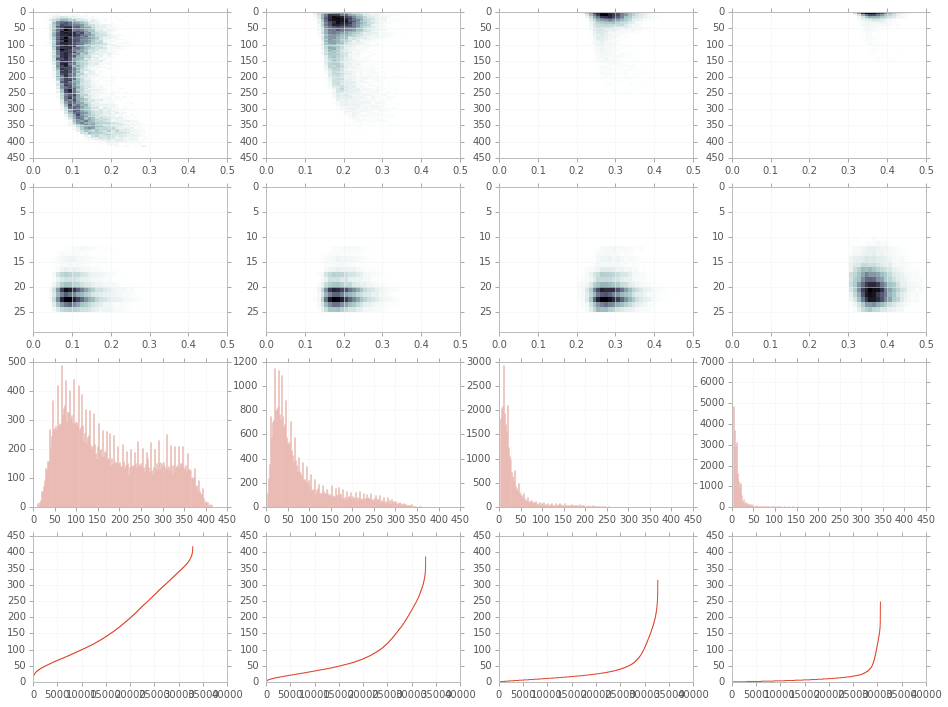

In [8]:
mpl.rcParams['figure.figsize'] = '16, 12'

for i, cutoff in enumerate([0.0, 0.1, 0.2, 0.3]):

    g = nx.read_gpickle('graphs/uniprot.escore' + str(cutoff) + '.pickle.bz2')
    nodes = g.nodes()
    _tmp = [(len(g.node[node]['gene_id']),\
             np.min(g.node[node]['enrichment_score']),\
             np.mean(g.node[node]['enrichment_score']),\
             np.max(g.node[node]['enrichment_score']),\
             g.degree(node)) for node in nodes]
    d, min_e, mean_e, max_e, k = zip(*_tmp)

    _a = plt.subplot(4, 4, 1 + i)
    h,x,y  = np.histogram2d(d, mean_e, [np.arange(0, 451, 5), np.arange(0, 0.51, 0.01)])
    _a.imshow(h, extent=[y[0], y[-1], x[-1], x[0]], interpolation='nearest', cmap='bone_r', aspect='auto')

    _a = plt.subplot(4, 4, 5 + i)
    h,x,y  = np.histogram2d(k, mean_e, [np.arange(30), np.arange(0, 0.51, 0.01)])
    _a.imshow(h, extent=[y[0], y[-1], x[-1], x[0]], interpolation='nearest', cmap='bone_r', aspect='auto')

    _a = plt.subplot(4, 4, 9 + i)
    _a.hist(d, 201, range=(0.0, 450.0));

    _a = plt.subplot(4, 4, 13 + i)
    _a.set_xlim([0, 40000])
    _a.set_ylim([1, 450])
    _a.plot(np.array(sorted(d)), c=plt.rcParams['axes.color_cycle'][0])

mpl.rcParams['figure.figsize'] = '16, 4.5'

## uniprot TF graph - Per species

In [ ]:
cutoff = 0.3
for species in ['Mus musculus', 'Saccharomyces cerevisiae', 'Caenorhabditis elegans',
                'Plasmodium falciparum', 'Homo sapiens', 'Drosophila melanogaster']:
    g = nx.empty_graph()

    for gene_data in session.query(GeneData).order_by(GeneData.uniprot):
        if gene_data.gene_info.species == species:
            for contig in gene_data.gene_info.genes[0].contigs:
                if contig.enrichment_score >= cutoff:
                    seq = id2kmer(contig.kmer)
                    enrichment_score = contig.enrichment_score

                    if seq in g:
                        g.node[seq]['gene_id'].append(gene_data.uniprot)
                        g.node[seq]['enrichment_score'].append(enrichment_score)
                    else:
                        g.add_node(seq, gene_id=[gene_data.uniprot])
                        g.add_node(seq, enrichment_score=[enrichment_score])

                    for mutant in snps(seq):
                        if mutant in g:
                            g.add_edge(seq, mutant)

    nx.write_gpickle(g, 'graphs/' + str(species) + '.escore' + str(cutoff) + '.pickle.bz2')

## GC content

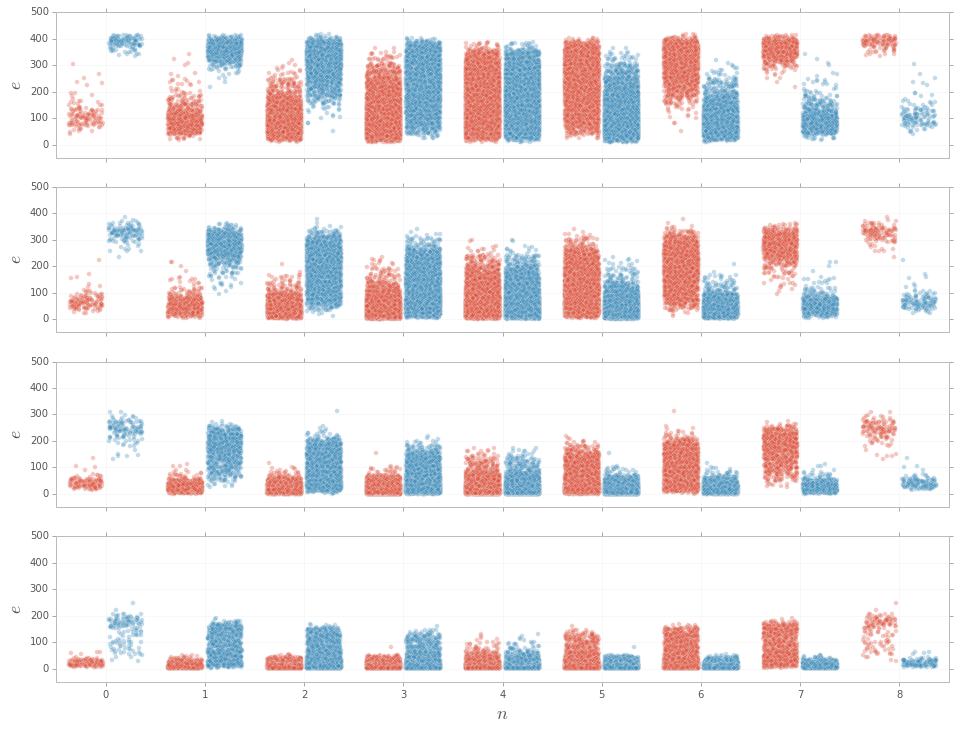

In [4]:
f, ax = plt.subplots(4, 1, sharex=True, figsize=(16, 12))

for i, cutoff in enumerate([0.0, 0.1, 0.2, 0.3]):

    g = nx.read_gpickle('graphs/uniprot.escore' + str(cutoff) + '.pickle.bz2')
    n = len(g)
    
    seq_deg = [len(g.node[node]['gene_id']) for node in g.nodes()]

    seq_nuc_count = {'A':list(), 'C':list(), 'G':list(), 'T':list()}
    for node in g.nodes():
        seq_nuc_count['A'].append(node.count('A'))
        seq_nuc_count['C'].append(node.count('C'))
        seq_nuc_count['G'].append(node.count('G'))
        seq_nuc_count['T'].append(node.count('T'))

    ax[i].set_ylim([-50, 500])
    ax[i].set_xlim([-0.5, 8.5])
    ax[i].set_xticks(range(9))
    ax[i].set_ylabel(r'$e$')

    ax[i].scatter((np.array(seq_nuc_count['A']) + np.array(seq_nuc_count['T']))
                  - 0.2 + np.random.uniform(-0.17, 0.17, n),
                  seq_deg, c=plt.rcParams['axes.color_cycle'][0], alpha=0.3)

    ax[i].scatter((np.array(seq_nuc_count['C']) + np.array(seq_nuc_count['G']))
                  + 0.2 + np.random.uniform(-0.17, 0.17, n),
                  seq_deg, c=plt.rcParams['axes.color_cycle'][1], alpha=0.3)

ax[-1].set_xlabel(r'$n$')

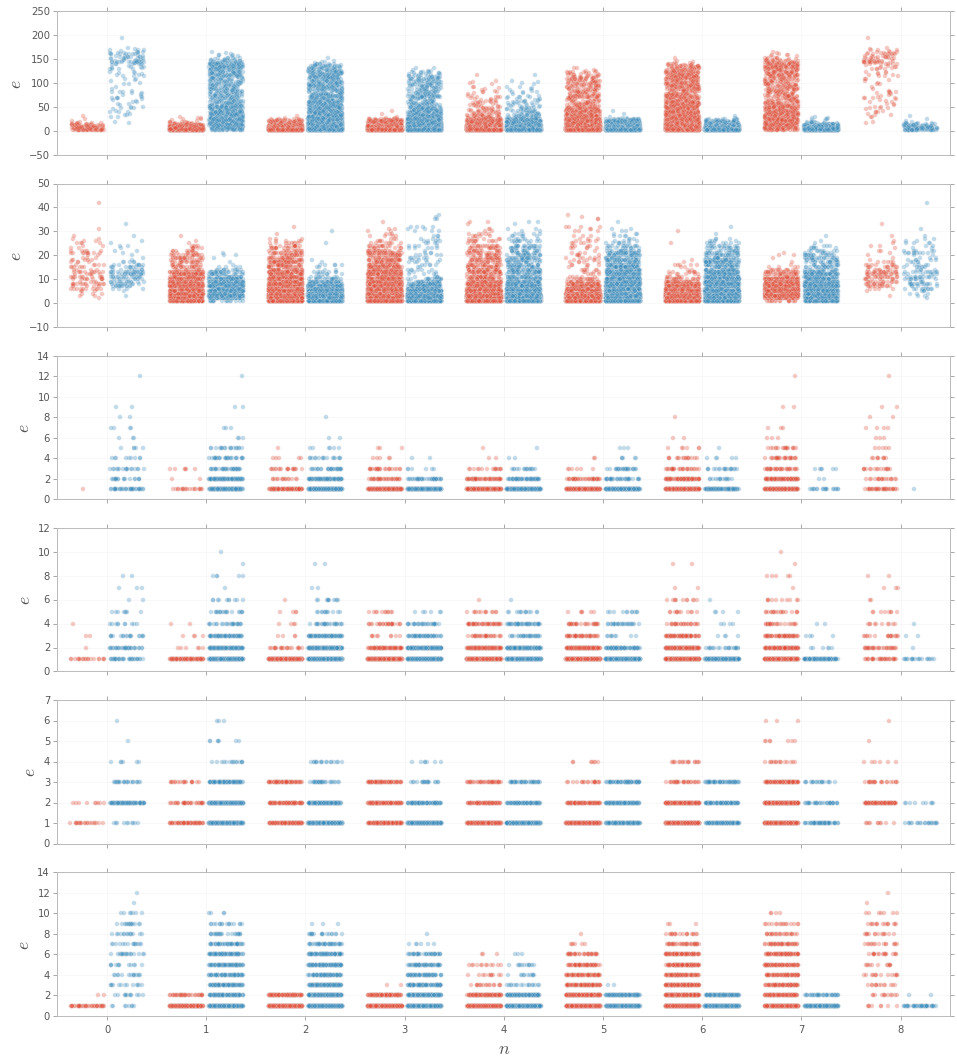

In [179]:
f, ax = plt.subplots(6, 1, sharex=True, figsize=(16, 12))

cutoff = 0.3
for i, species in enumerate(['Mus musculus', 'Saccharomyces cerevisiae', 'Caenorhabditis elegans',
                            'Plasmodium falciparum', 'Homo sapiens', 'Drosophila melanogaster']):

    g = nx.read_gpickle('graphs/' + str(species) + '.escore' + str(cutoff) + '.pickle.bz2')
    n = len(g)
    
    seq_deg = [len(g.node[node]['gene_id']) for node in g.nodes()]

    seq_nuc_count = {'A':list(), 'C':list(), 'G':list(), 'T':list()}
    for node in g.nodes():
        seq_nuc_count['A'].append(node.count('A'))
        seq_nuc_count['C'].append(node.count('C'))
        seq_nuc_count['G'].append(node.count('G'))
        seq_nuc_count['T'].append(node.count('T'))

#     ax[i].set_ylim([-20, 200])
    ax[i].set_xlim([-0.5, 8.5])
    ax[i].set_xticks(range(9))
    ax[i].set_ylabel(r'$e$')

    ax[i].scatter((np.array(seq_nuc_count['A']) + np.array(seq_nuc_count['T']))
                  - 0.2 + np.random.uniform(-0.17, 0.17, n),
                  seq_deg, c=plt.rcParams['axes.color_cycle'][0], alpha=0.3)

    ax[i].scatter((np.array(seq_nuc_count['C']) + np.array(seq_nuc_count['G']))
                  + 0.2 + np.random.uniform(-0.17, 0.17, n),
                  seq_deg, c=plt.rcParams['axes.color_cycle'][1], alpha=0.3)

ax[-1].set_xlabel(r'$n$')

### 0.0

In [153]:
g = nx.read_gpickle('graphs/uniprot.escore0.0.pickle.bz2')
print(len(g))

32896


In [154]:
seqs = g.nodes()

seq_deg = [len(g.node[node]['gene_id']) for node in seqs]

seq_nuc_count = {'A':list(), 'C':list(), 'G':list(), 'T':list()}
for node in seqs:
    seq_nuc_count['A'].append(node.count('A'))
    seq_nuc_count['C'].append(node.count('C'))
    seq_nuc_count['G'].append(node.count('G'))
    seq_nuc_count['T'].append(node.count('T'))

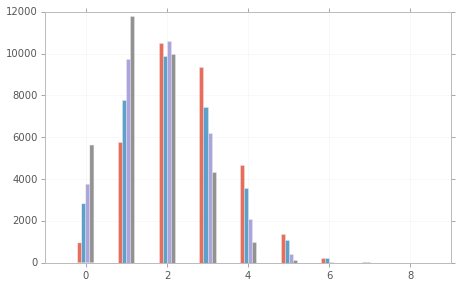

In [146]:
_a = plt.subplot(1, 2, 1)
_a.hist([np.array(seq_nuc_count['A']), np.array(seq_nuc_count['C']),
         np.array(seq_nuc_count['G']), np.array(seq_nuc_count['T'])], 17, range=(0.0,8.5),
        align='left', alpha=0.8);

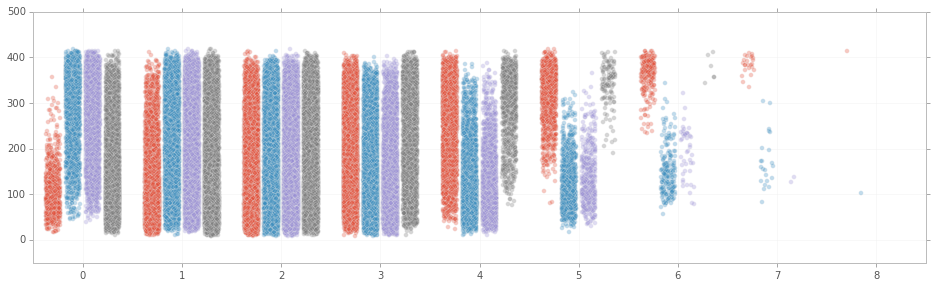

In [155]:
_a = plt.subplot(1, 1, 1)
_a.set_ylim([-50, 500])
_a.set_xlim([-0.5, 8.5])
_a.set_xticks(range(9))

_a.scatter(np.array(seq_nuc_count['A']) - 0.3 + np.random.uniform(-0.07, 0.07, 32896), seq_deg,
           c=plt.rcParams['axes.color_cycle'][0], alpha=0.3)
_a.scatter(np.array(seq_nuc_count['C']) - 0.1 + np.random.uniform(-0.07, 0.07, 32896), seq_deg,
           c=plt.rcParams['axes.color_cycle'][1], alpha=0.3)
_a.scatter(np.array(seq_nuc_count['G']) + 0.1 + np.random.uniform(-0.07, 0.07, 32896), seq_deg,
           c=plt.rcParams['axes.color_cycle'][2], alpha=0.3)
_a.scatter(np.array(seq_nuc_count['T']) + 0.3 + np.random.uniform(-0.07, 0.07, 32896), seq_deg,
           c=plt.rcParams['axes.color_cycle'][3], alpha=0.3)

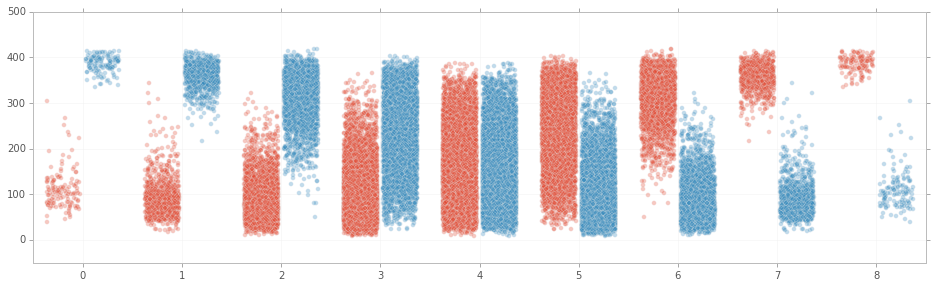

In [157]:
_a = plt.subplot(1, 1, 1)
_a.set_ylim([-50, 500])
_a.set_xlim([-0.5, 8.5])
_a.set_xticks(range(9))

_a.scatter((np.array(seq_nuc_count['A']) + np.array(seq_nuc_count['T'])) - 0.2 + np.random.uniform(-0.17, 0.17, 32896),
           seq_deg, c=plt.rcParams['axes.color_cycle'][0], alpha=0.3)

_a.scatter((np.array(seq_nuc_count['C']) + np.array(seq_nuc_count['G'])) + 0.2 + np.random.uniform(-0.17, 0.17, 32896),
           seq_deg, c=plt.rcParams['axes.color_cycle'][1], alpha=0.3)

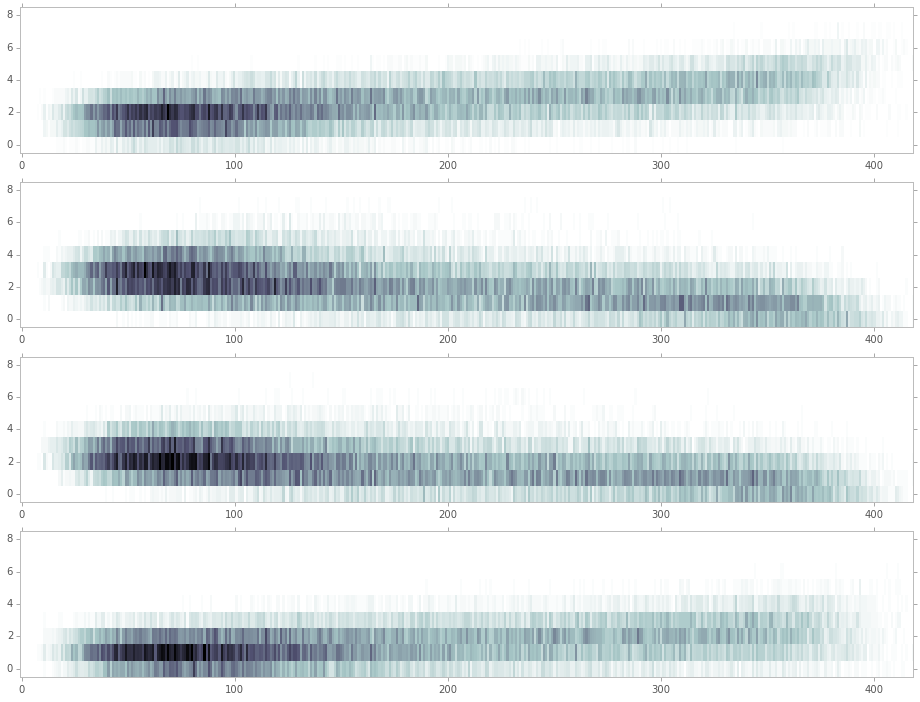

In [36]:
mpl.rcParams['figure.figsize'] = '16, 12'

_a = plt.subplot(4, 1, 1)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['A'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(h, interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

_a = plt.subplot(4, 1, 2)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['C'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(h, interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

_a = plt.subplot(4, 1, 3)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['G'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(h, interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

_a = plt.subplot(4, 1, 4)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['T'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(h, interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

mpl.rcParams['figure.figsize'] = '16, 4.5'

### 0.35

In [158]:
g = nx.read_gpickle('graphs/uniprot.escore0.35.pickle.bz2')
print(len(g))

27211


In [159]:
seqs = g.nodes()

seq_deg = [len(g.node[node]['gene_id']) for node in seqs]

seq_nuc_count = {'A':list(), 'C':list(), 'G':list(), 'T':list()}
for node in seqs:
    seq_nuc_count['A'].append(node.count('A'))
    seq_nuc_count['C'].append(node.count('C'))
    seq_nuc_count['G'].append(node.count('G'))
    seq_nuc_count['T'].append(node.count('T'))

([array([  7.78000000e+02,   0.00000000e+00,   4.72600000e+03,
           0.00000000e+00,   8.51400000e+03,   0.00000000e+00,
           7.69000000e+03,   0.00000000e+00,   3.97700000e+03,
           0.00000000e+00,   1.26000000e+03,   0.00000000e+00,
           2.41000000e+02,   0.00000000e+00,   2.40000000e+01,
           0.00000000e+00,   1.00000000e+00]),
  array([  2.43900000e+03,   0.00000000e+00,   6.62200000e+03,
           0.00000000e+00,   8.16800000e+03,   0.00000000e+00,
           5.92700000e+03,   0.00000000e+00,   2.87500000e+03,
           0.00000000e+00,   9.50000000e+02,   0.00000000e+00,
           2.07000000e+02,   0.00000000e+00,   2.20000000e+01,
           0.00000000e+00,   1.00000000e+00]),
  array([  3.27600000e+03,   0.00000000e+00,   8.26500000e+03,
           0.00000000e+00,   8.62600000e+03,   0.00000000e+00,
           4.94500000e+03,   0.00000000e+00,   1.68700000e+03,
           0.00000000e+00,   3.66000000e+02,   0.00000000e+00,
           4.40000000e+0

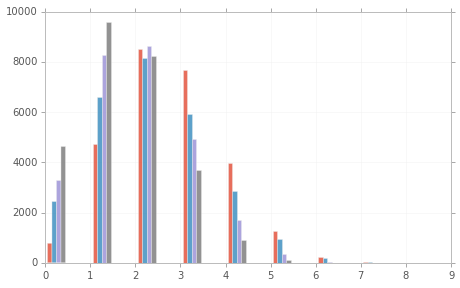

In [127]:
_a = plt.subplot(1, 2, 1)
_a.hist([np.array(seq_nuc_count['A']), np.array(seq_nuc_count['C']),
         np.array(seq_nuc_count['G']), np.array(seq_nuc_count['T'])], 17, range=(0.0,8.5), alpha=0.8);

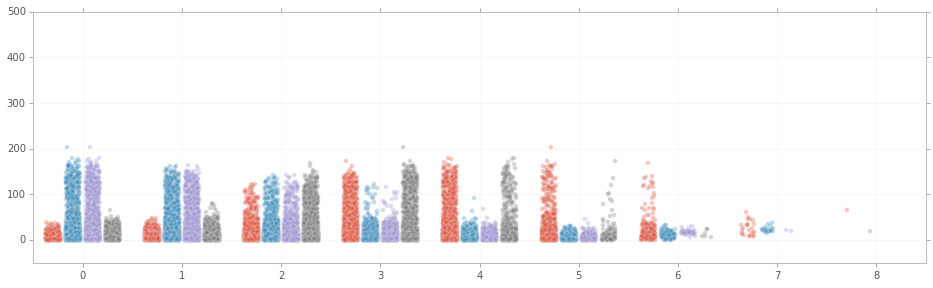

In [161]:
_a = plt.subplot(1, 1, 1)
_a.set_ylim([-50, 500])
_a.set_xlim([-0.5, 8.5])
_a.set_xticks(range(9))

_a.scatter(np.array(seq_nuc_count['A']) - 0.3 + np.random.uniform(-0.07, 0.07, 27211), seq_deg,
           c=plt.rcParams['axes.color_cycle'][0], alpha=0.3)
_a.scatter(np.array(seq_nuc_count['C']) - 0.1 + np.random.uniform(-0.07, 0.07, 27211), seq_deg,
           c=plt.rcParams['axes.color_cycle'][1], alpha=0.3)
_a.scatter(np.array(seq_nuc_count['G']) + 0.1 + np.random.uniform(-0.07, 0.07, 27211), seq_deg,
           c=plt.rcParams['axes.color_cycle'][2], alpha=0.3)
_a.scatter(np.array(seq_nuc_count['T']) + 0.3 + np.random.uniform(-0.07, 0.07, 27211), seq_deg,
           c=plt.rcParams['axes.color_cycle'][3], alpha=0.3)

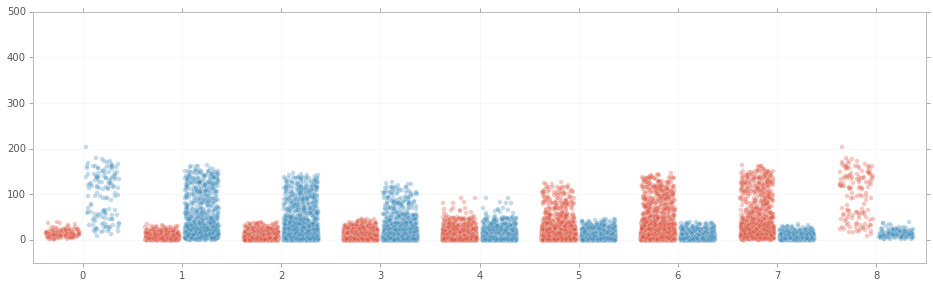

In [162]:
_a = plt.subplot(1, 1, 1)
_a.set_ylim([-50, 500])
_a.set_xlim([-0.5, 8.5])
_a.set_xticks(range(9))

_a.scatter((np.array(seq_nuc_count['A']) + np.array(seq_nuc_count['T'])) - 0.2 + np.random.uniform(-0.17, 0.17, 27211),
           seq_deg, c=plt.rcParams['axes.color_cycle'][0], alpha=0.3)

_a.scatter((np.array(seq_nuc_count['C']) + np.array(seq_nuc_count['G'])) + 0.2 + np.random.uniform(-0.17, 0.17, 27211),
           seq_deg, c=plt.rcParams['axes.color_cycle'][1], alpha=0.3)

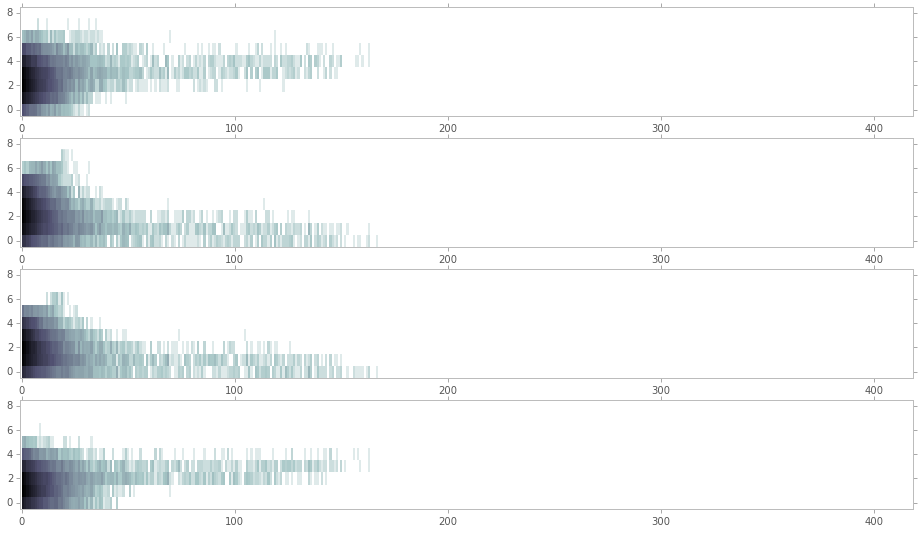

In [43]:
mpl.rcParams['figure.figsize'] = '16, 9'

_a = plt.subplot(4, 1, 1)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['A'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(np.log(h), interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

_a = plt.subplot(4, 1, 2)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['C'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(np.log(h), interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

_a = plt.subplot(4, 1, 3)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['G'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(np.log(h), interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

_a = plt.subplot(4, 1, 4)
_a.set_ylim([-0.5, 8.5])
h,x,y  = np.histogram2d(seq_nuc_count['T'], seq_deg, [np.arange(9), np.arange(0, 420, 1)])
_a.imshow(np.log(h), interpolation='nearest', cmap='bone_r', aspect='auto')
_a.grid(False)

mpl.rcParams['figure.figsize'] = '16, 4.5'